In [3]:
from google.colab import drive
drive.mount("/content/drive")

import os
import sys
import tensorflow as tf

# Projektets rot i Google Drive
PROJECT_DIR = "/content/drive/MyDrive/sepsis-timeline-project"
SRC_DIR = f"{PROJECT_DIR}/src"

# Byt arbetskatalog till projektroten
os.chdir(PROJECT_DIR)

# Lägg src/ i PYTHONPATH (stabilast i Colab)
if SRC_DIR not in sys.path:
    sys.path.insert(0, SRC_DIR)

# Sanity checks
print("✅ Current working directory:", os.getcwd())
print("✅ src/ in sys.path:", SRC_DIR in sys.path)
print("✅ TensorFlow version:", tf.__version__)
print("✅ GPU available:", tf.config.list_physical_devices("GPU"))


Mounted at /content/drive
✅ Current working directory: /content/drive/MyDrive/sepsis-timeline-project
✅ src/ in sys.path: True
✅ TensorFlow version: 2.19.0
✅ GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# 04_model_gru.ipynb
# ============================================================
# Steg 7 — GRU-modell (dev5000)
# ------------------------------------------------------------
# I den här notebooken gör jag:
# 1) Laddar färdigprocessade train/val/test-tensorer från data/processed/dev5000
# 2) Bygger en första GRU-baseline i Keras
# 3) Tränar med class weights + callbacks (EarlyStopping, checkpoint, ReduceLR)
# 4) Utvärderar på val och test (ROC-AUC + PR-AUC)
# 5) Sparar figurer (loss, AUC, ROC/PR, confusion matrix) till outputs/figures
#    så att de lätt kan inkluderas i LaTeX-rapporten senare.
# ============================================================


In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve,
    confusion_matrix, classification_report
)

print("✅ TensorFlow:", tf.__version__)


✅ TensorFlow: 2.19.0


In [4]:
# ============================================================
# Välj vilken processed-folder vi tränar på
# (här kör vi dev5000)
# ============================================================
PROCESSED_NAME = "dev5000"
PROCESSED_DIR = os.path.join(PROJECT_DIR, "data", "processed", PROCESSED_NAME)

FIG_DIR = os.path.join(PROJECT_DIR, "outputs", "figures")
CKPT_DIR = os.path.join(PROJECT_DIR, "outputs", "checkpoints")
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(CKPT_DIR, exist_ok=True)

print("✅ PROCESSED_DIR:", PROCESSED_DIR)
print("✅ FIG_DIR:", FIG_DIR)
print("✅ CKPT_DIR:", CKPT_DIR)


✅ PROCESSED_DIR: /content/drive/MyDrive/sepsis-timeline-project/data/processed/dev5000
✅ FIG_DIR: /content/drive/MyDrive/sepsis-timeline-project/outputs/figures
✅ CKPT_DIR: /content/drive/MyDrive/sepsis-timeline-project/outputs/checkpoints


In [5]:
train_X = np.load(os.path.join(PROCESSED_DIR, "train_X.npy"))
train_y = np.load(os.path.join(PROCESSED_DIR, "train_y.npy"))
val_X   = np.load(os.path.join(PROCESSED_DIR, "val_X.npy"))
val_y   = np.load(os.path.join(PROCESSED_DIR, "val_y.npy"))
test_X  = np.load(os.path.join(PROCESSED_DIR, "test_X.npy"))
test_y  = np.load(os.path.join(PROCESSED_DIR, "test_y.npy"))

meta_path = os.path.join(PROCESSED_DIR, "meta.json")
meta = json.load(open(meta_path, "r")) if os.path.exists(meta_path) else {}

print("✅ Shapes:")
print("  train:", train_X.shape, train_y.shape)
print("  val  :", val_X.shape, val_y.shape)
print("  test :", test_X.shape, test_y.shape)

SEQ_LEN = train_X.shape[1]
NUM_FEATURES = train_X.shape[2]

print("✅ SEQ_LEN:", SEQ_LEN, " NUM_FEATURES:", NUM_FEATURES)
print("✅ Pos-rate train/val/test:",
      float(train_y.mean()), float(val_y.mean()), float(test_y.mean()))


✅ Shapes:
  train: (12825, 48, 80) (12825,)
  val  : (2893, 48, 80) (2893,)
  test : (2878, 48, 80) (2878,)
✅ SEQ_LEN: 48  NUM_FEATURES: 80
✅ Pos-rate train/val/test: 0.1352046783625731 0.11959903214656066 0.1296038915913829


In [6]:
# ============================================================
# tf.data pipelines (snabbare träning)
# ============================================================
BATCH_SIZE = 128

train_ds = tf.data.Dataset.from_tensor_slices((train_X, train_y))
train_ds = train_ds.shuffle(min(len(train_X), 10000), seed=42).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_X, val_y))
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((test_X, test_y))
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("✅ train batches:", len(list(train_ds.take(1))))


✅ train batches: 1


In [7]:
# ============================================================
# Class weights för obalanserad data
# (ger mer "straff" när modellen missar sepsis)
# ============================================================
pos = float(train_y.sum())
neg = float(len(train_y) - pos)

# enkel standard: vikt(1) = neg/pos, vikt(0)=1
w_pos = (neg / pos) if pos > 0 else 1.0
class_weight = {0: 1.0, 1: w_pos}

print("✅ class_weight:", class_weight)


✅ class_weight: {0: 1.0, 1: 6.396193771626297}


In [8]:
# ============================================================
# GRU baseline:
# - 1 GRU-lager som läser sekvensen
# - Litet dense-head
# - Dropout för att minska överanpassning
# ============================================================
def build_gru_baseline(seq_len, num_features, hidden_units=128, dropout=0.2):
    inputs = keras.Input(shape=(seq_len, num_features), name="timeseries")

    x = layers.GRU(hidden_units, dropout=dropout, recurrent_dropout=0.0, name="gru")(inputs)

    x = layers.Dense(64, activation="relu", name="dense_64")(x)
    x = layers.Dropout(dropout, name="dropout")(x)

    outputs = layers.Dense(1, activation="sigmoid", name="p_sepsis")(x)

    model = keras.Model(inputs, outputs, name="gru_baseline")

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=[
            keras.metrics.AUC(name="auc"),
            keras.metrics.AUC(name="pr_auc", curve="PR"),
            keras.metrics.Precision(name="precision"),
            keras.metrics.Recall(name="recall"),
        ],
    )
    return model

model = build_gru_baseline(SEQ_LEN, NUM_FEATURES, hidden_units=128, dropout=0.2)
model.summary()


Model: "gru_baseline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ timeseries (InputLayer)         │ (None, 48, 80)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 128)            │        80,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_sepsis (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,961 (347.50 KB)

 Trainable params: 88,961 (347.50 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# ============================================================
# Callbacks:
# - monitor val_pr_auc (mer relevant än ROC-AUC vid obalans)
# - spara bästa modellen
# - sänk LR om förbättring stannar
# ============================================================
ckpt_path = os.path.join(CKPT_DIR, f"best_gru_baseline_{PROCESSED_NAME}.keras")

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_pr_auc", mode="max",
        patience=6, restore_best_weights=True
    ),
    keras.callbacks.ModelCheckpoint(
        ckpt_path, monitor="val_pr_auc", mode="max",
        save_best_only=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_pr_auc", mode="max",
        factor=0.5, patience=2, min_lr=1e-5
    )
]

print("✅ Checkpoint:", ckpt_path)


✅ Checkpoint: /content/drive/MyDrive/sepsis-timeline-project/outputs/checkpoints/best_gru_baseline_dev5000.keras


In [10]:
EPOCHS = 30

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weight,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - auc: 0.6279 - loss: 1.1370 - pr_auc: 0.1949 - precision: 0.1808 - recall: 0.5747 - val_auc: 0.6481 - val_loss: 0.6392 - val_pr_auc: 0.1691 - val_precision: 0.1888 - val_recall: 0.6792 - learning_rate: 0.0010
Epoch 2/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - auc: 0.7613 - loss: 1.0185 - pr_auc: 0.3463 - precision: 0.2368 - recall: 0.7556 - val_auc: 0.6114 - val_loss: 0.5666 - val_pr_auc: 0.1584 - val_precision: 0.1734 - val_recall: 0.4075 - learning_rate: 0.0010
Epoch 3/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - auc: 0.8261 - loss: 0.8867 - pr_auc: 0.4373 - precision: 0.3017 - recall: 0.7831 - val_auc: 0.6020 - val_loss: 0.5754 - val_pr_auc: 0.1605 - val_precision: 0.1509 - val_recall: 0.4046 - learning_rate: 0.0010
Epoch 4/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - auc: 0.8649 - loss: 0.7809 - pr_auc: 0.5276 - precision: 0.3327 - recall: 0.7897 - val_auc: 0.5656 - val_loss: 0.6116 - val_pr_auc: 0.1428 - val_precision: 0.1

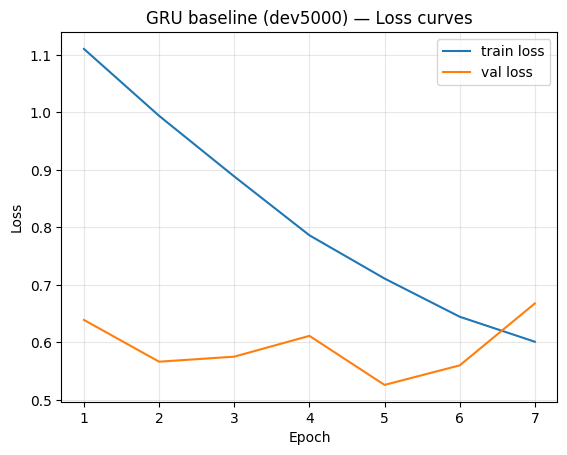

✅ Sparad: /content/drive/MyDrive/sepsis-timeline-project/outputs/figures/gru_baseline_dev5000_learning_loss.png


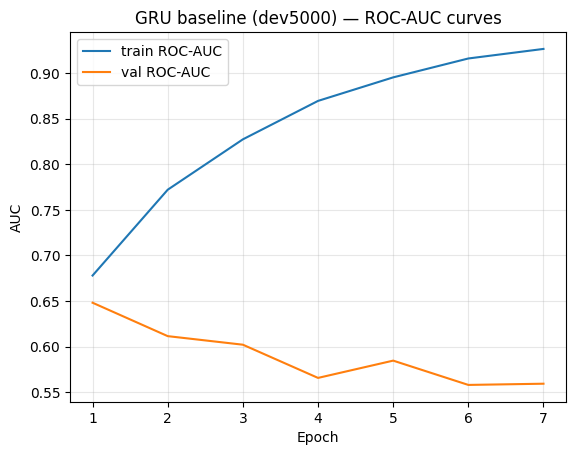

✅ Sparad: /content/drive/MyDrive/sepsis-timeline-project/outputs/figures/gru_baseline_dev5000_learning_auc.png


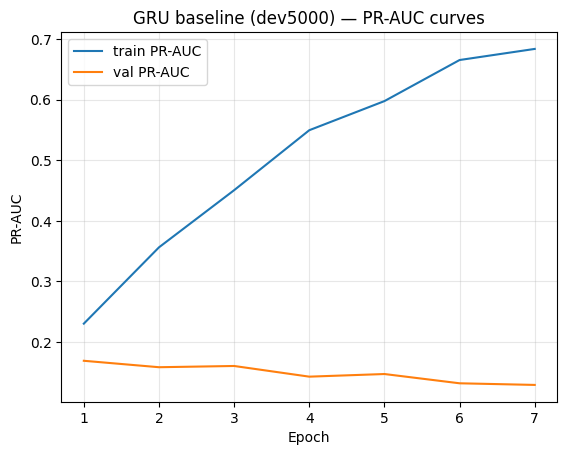

✅ Sparad: /content/drive/MyDrive/sepsis-timeline-project/outputs/figures/gru_baseline_dev5000_learning_pr_auc.png


In [11]:
hist = history.history
epochs = np.arange(1, len(hist["loss"]) + 1)

# --- Loss
plt.figure()
plt.plot(epochs, hist["loss"], label="train loss")
plt.plot(epochs, hist["val_loss"], label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"GRU baseline ({PROCESSED_NAME}) — Loss curves")
plt.grid(True, alpha=0.3)
plt.legend()
out_loss = os.path.join(FIG_DIR, f"gru_baseline_{PROCESSED_NAME}_learning_loss.png")
plt.savefig(out_loss, dpi=200, bbox_inches="tight")
plt.show()
print("✅ Sparad:", out_loss)

# --- ROC-AUC
plt.figure()
plt.plot(epochs, hist["auc"], label="train ROC-AUC")
plt.plot(epochs, hist["val_auc"], label="val ROC-AUC")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.title(f"GRU baseline ({PROCESSED_NAME}) — ROC-AUC curves")
plt.grid(True, alpha=0.3)
plt.legend()
out_auc = os.path.join(FIG_DIR, f"gru_baseline_{PROCESSED_NAME}_learning_auc.png")
plt.savefig(out_auc, dpi=200, bbox_inches="tight")
plt.show()
print("✅ Sparad:", out_auc)

# --- PR-AUC
plt.figure()
plt.plot(epochs, hist["pr_auc"], label="train PR-AUC")
plt.plot(epochs, hist["val_pr_auc"], label="val PR-AUC")
plt.xlabel("Epoch")
plt.ylabel("PR-AUC")
plt.title(f"GRU baseline ({PROCESSED_NAME}) — PR-AUC curves")
plt.grid(True, alpha=0.3)
plt.legend()
out_prauc = os.path.join(FIG_DIR, f"gru_baseline_{PROCESSED_NAME}_learning_pr_auc.png")
plt.savefig(out_prauc, dpi=200, bbox_inches="tight")
plt.show()
print("✅ Sparad:", out_prauc)


In [12]:
def predict_probs(model, X, batch_size=256):
    return model.predict(X, batch_size=batch_size, verbose=0).reshape(-1)

def plot_roc_pr(y_true, y_prob, title_prefix, out_prefix):
    # ROC
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = roc_auc_score(y_true, y_prob)

    plt.figure()
    plt.plot(fpr, tpr, label=f"{title_prefix} ROC (AUC={roc_auc:.3f})")
    plt.plot([0,1], [0,1], "--", label="Random")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{title_prefix} — ROC curve")
    plt.grid(True, alpha=0.3)
    plt.legend()
    out_roc = os.path.join(FIG_DIR, f"{out_prefix}_roc.png")
    plt.savefig(out_roc, dpi=200, bbox_inches="tight")
    plt.show()

    # PR
    prec, rec, _ = precision_recall_curve(y_true, y_prob)
    pr_auc = average_precision_score(y_true, y_prob)

    plt.figure()
    plt.plot(rec, prec, label=f"{title_prefix} PR (AP={pr_auc:.3f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{title_prefix} — Precision-Recall curve")
    plt.grid(True, alpha=0.3)
    plt.legend()
    out_pr = os.path.join(FIG_DIR, f"{out_prefix}_pr.png")
    plt.savefig(out_pr, dpi=200, bbox_inches="tight")
    plt.show()

    return roc_auc, pr_auc, out_roc, out_pr


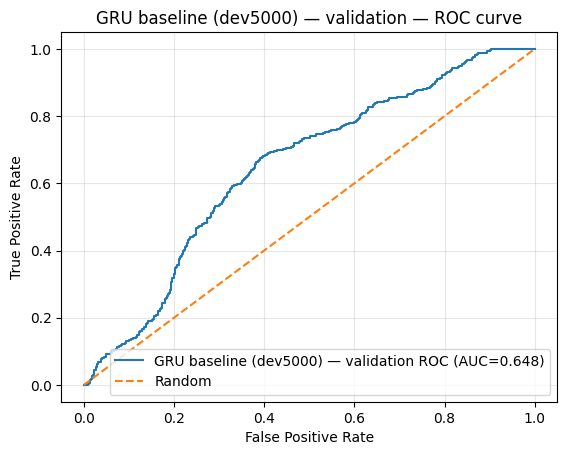

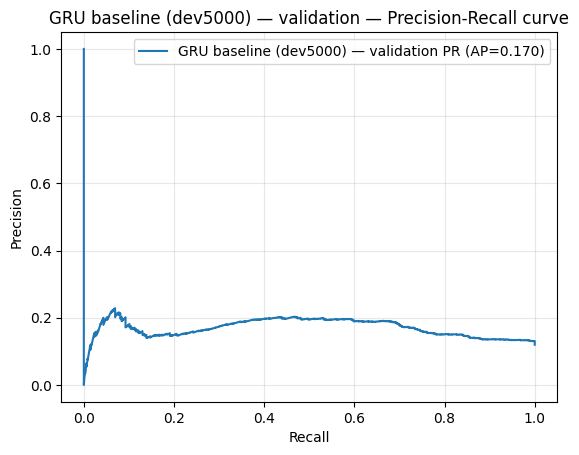

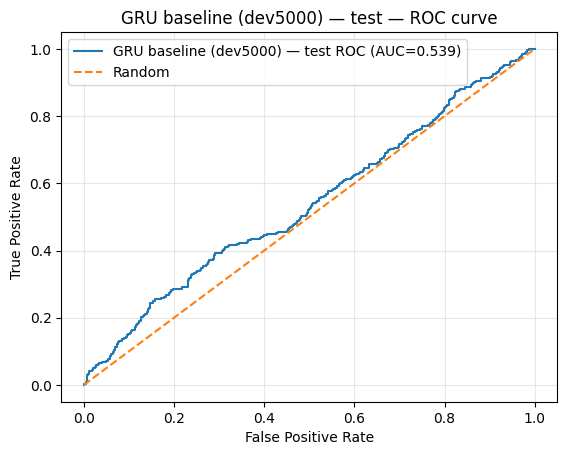

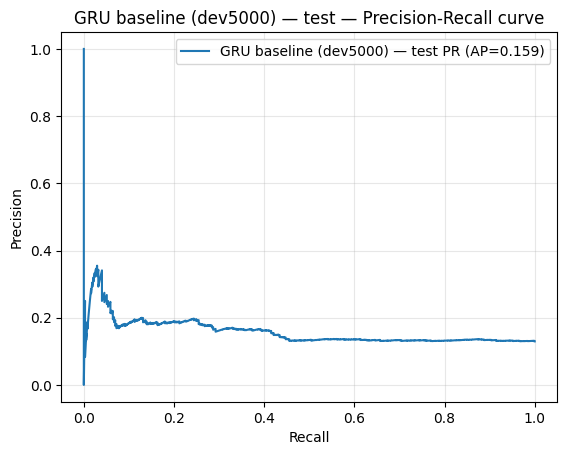

📌 VAL  ROC-AUC=0.6479 | PR-AUC=0.1700
📌 TEST ROC-AUC=0.5388 | PR-AUC=0.1587


In [13]:
val_prob  = predict_probs(model, val_X)
test_prob = predict_probs(model, test_X)

val_roc, val_pr, out_val_roc, out_val_pr = plot_roc_pr(
    val_y, val_prob,
    title_prefix=f"GRU baseline ({PROCESSED_NAME}) — validation",
    out_prefix=f"gru_baseline_{PROCESSED_NAME}_val"
)

test_roc, test_pr, out_test_roc, out_test_pr = plot_roc_pr(
    test_y, test_prob,
    title_prefix=f"GRU baseline ({PROCESSED_NAME}) — test",
    out_prefix=f"gru_baseline_{PROCESSED_NAME}_test"
)

print(f"📌 VAL  ROC-AUC={val_roc:.4f} | PR-AUC={val_pr:.4f}")
print(f"📌 TEST ROC-AUC={test_roc:.4f} | PR-AUC={test_pr:.4f}")


Confusion matrix (TEST):
 [[1159 1346]
 [ 162  211]]

Classification report (TEST):
               precision    recall  f1-score   support

           0      0.877     0.463     0.606      2505
           1      0.136     0.566     0.219       373

    accuracy                          0.476      2878
   macro avg      0.506     0.514     0.412      2878
weighted avg      0.781     0.476     0.556      2878



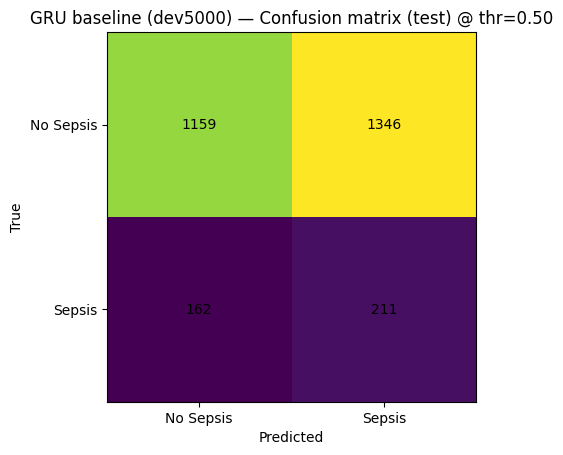

✅ Sparad: /content/drive/MyDrive/sepsis-timeline-project/outputs/figures/gru_baseline_dev5000_confusion_test_thr0.50.png


In [14]:
# ============================================================
# Confusion matrix på TEST med threshold=0.50 (standard)
# (vi kan senare optimera tröskel om vi vill)
# ============================================================
thr = 0.50
test_pred = (test_prob >= thr).astype(int)

cm = confusion_matrix(test_y, test_pred)
print("Confusion matrix (TEST):\n", cm)
print("\nClassification report (TEST):\n", classification_report(test_y, test_pred, digits=3))

plt.figure()
plt.imshow(cm)
plt.title(f"GRU baseline ({PROCESSED_NAME}) — Confusion matrix (test) @ thr={thr:.2f}")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks([0,1], ["No Sepsis", "Sepsis"])
plt.yticks([0,1], ["No Sepsis", "Sepsis"])

for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha="center", va="center")

out_cm = os.path.join(FIG_DIR, f"gru_baseline_{PROCESSED_NAME}_confusion_test_thr{thr:.2f}.png")
plt.savefig(out_cm, dpi=200, bbox_inches="tight")
plt.show()
print("✅ Sparad:", out_cm)


In [15]:
summary = {
    "model": "gru_baseline",
    "processed_name": PROCESSED_NAME,
    "seq_len": int(SEQ_LEN),
    "num_features": int(NUM_FEATURES),
    "class_weight": class_weight,
    "val_roc_auc": float(val_roc),
    "val_pr_auc": float(val_pr),
    "test_roc_auc": float(test_roc),
    "test_pr_auc": float(test_pr),
    "checkpoint": ckpt_path,
    "figures": {
        "loss": os.path.basename(out_loss),
        "auc": os.path.basename(out_auc),
        "pr_auc": os.path.basename(out_prauc),
        "roc_val": os.path.basename(out_val_roc),
        "pr_val": os.path.basename(out_val_pr),
        "roc_test": os.path.basename(out_test_roc),
        "pr_test": os.path.basename(out_test_pr),
        "cm_test": os.path.basename(out_cm),
    }
}

print("⭐ GRU (baseline) — sammanfattning:")
for k, v in summary.items():
    if k != "figures":
        print("-", k, ":", v)

print("\nFigurer:")
for k, v in summary["figures"].items():
    print("-", k, ":", v)


⭐ GRU (baseline) — sammanfattning:
- model : gru_baseline
- processed_name : dev5000
- seq_len : 48
- num_features : 80
- class_weight : {0: 1.0, 1: 6.396193771626297}
- val_roc_auc : 0.647911744747873
- val_pr_auc : 0.169994721342631
- test_roc_auc : 0.5388076394128634
- test_pr_auc : 0.15866706563819677
- checkpoint : /content/drive/MyDrive/sepsis-timeline-project/outputs/checkpoints/best_gru_baseline_dev5000.keras

Figurer:
- loss : gru_baseline_dev5000_learning_loss.png
- auc : gru_baseline_dev5000_learning_auc.png
- pr_auc : gru_baseline_dev5000_learning_pr_auc.png
- roc_val : gru_baseline_dev5000_val_roc.png
- pr_val : gru_baseline_dev5000_val_pr.png
- roc_test : gru_baseline_dev5000_test_roc.png
- pr_test : gru_baseline_dev5000_test_pr.png
- cm_test : gru_baseline_dev5000_confusion_test_thr0.50.png
